# Pneumonia Detection from Chest X-ray through Deep Learning

## I. Overview
This project uses convolutional neural networks (CNN) for chest x-ray image classification to identify whether patients have pneumonia or not. The data contains normal and pneumonia x-ray images. The radiology department can use my model to predict pneumonia.

## II. Business Problem
Working for a radiology department, my job is to build a machine learning model which can classify the chest x-ray and predict unseen images as either pneumonia or normal, thus improve the efficiency of the department.

## III. Data Understanding and Preparation
The dataset acquired from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) is organized into 3 folders (train, test, val) which contain sub-folders for each image category (Pneumonia/Normal). There is a total of 5856 x-ray images (JPEG).<br>

### Note 1:
- This notebook was run in Google Colab. Since I did not complete this notebook in one day, if I generated some new ideas, I only ran the updated codes. If you see some outputs have blank brackets, which means those codes were successfully run before and kept as saved version for further analysis. 

- The previous version was saved in <u>*additional*</u> folder

In [1]:
import os

import pandas as pd
import numpy as np
np.random.seed(24)
# Set for displaying prediction probability for later
np.set_printoptions(precision=6, suppress=True)  # if absolute value < 1e-4, set equal to 0

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from google.colab import drive

In [3]:
from tensorflow import random
random.set_seed(24)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

# Implementation of the scikit-learn classifier API for Keras
from keras.wrappers.scikit_learn import KerasClassifier

In [4]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [5]:
# Get the current working directory
print(os.getcwd())

/content


In [6]:
# Drive path is the path where I upload the zip file
drive_path = '/gdrive/MyDrive/chest_xray.zip'

# Expect to move the zip file into the local path
local_path = '/content'

In [7]:
# Copy the file in drive path
!cp '{drive_path}' .

# Change the file from drive path to the local path
os.chdir(local_path)

# Unzip the file
!unzip -q 'chest_xray.zip'

In [8]:
# Check the number of images in each sub-folders

# Train
train_normal = '/content/chest_xray/train/NORMAL'
train_pneumonia = '/content/chest_xray/train/PNEUMONIA'

print("Train Normal:", len(os.listdir(train_normal)))
print("Train Pneumonia:", len(os.listdir(train_pneumonia)))
print("Train Total:", len(os.listdir(train_normal)) + len(os.listdir(train_pneumonia)))

# Test
test_normal = '/content/chest_xray/test/NORMAL'
test_pneumonia = '/content/chest_xray/test/PNEUMONIA'

print("\nTest Normal:", len(os.listdir(test_normal)))
print("Test Pneumonia:", len(os.listdir(test_pneumonia)))
print("Test Total:", len(os.listdir(test_normal)) + len(os.listdir(test_pneumonia)))

# Validation
val_normal = '/content/chest_xray/val/NORMAL'
val_pneumonia = '/content/chest_xray/val/PNEUMONIA'

print("\nVal Normal:", len(os.listdir(val_normal)))
print("Val Pneumonia:", len(os.listdir(val_pneumonia)))
print("Val Total:", len(os.listdir(val_normal)) + len(os.listdir(val_pneumonia)))

Train Normal: 1341
Train Pneumonia: 3875
Train Total: 5216

Test Normal: 234
Test Pneumonia: 390
Test Total: 624

Val Normal: 8
Val Pneumonia: 8
Val Total: 16


In [9]:
# Create file directory
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

In [10]:
# Create data generator
# Get all the train data (5216), test data (624), validation data (16) in the corresponding directory
# Scale data
# Set each image to 128×128 px
# Set binary class mode

train_generator = ImageDataGenerator(rescale=1./255)\
                  .flow_from_directory(train_dir, target_size=(128,128), batch_size=5216, class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255)\
                 .flow_from_directory(test_dir, target_size=(128,128), batch_size=624, class_mode='binary') 

val_generator = ImageDataGenerator(rescale=1./255)\
                .flow_from_directory(val_dir, target_size=(128,128), batch_size=16, class_mode='binary') 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
# Create the data sets
# next - retrieve the next item from iterator
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)
X_val, y_val = next(val_generator)

In [12]:
# Check the shape
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))

print ("\nX_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

print ("\nX_val shape: " + str(X_val.shape))
print ("y_val shape: " + str(y_val.shape))

X_train shape: (5216, 128, 128, 3)
y_train shape: (5216,)

X_test shape: (624, 128, 128, 3)
y_test shape: (624,)

X_val shape: (16, 128, 128, 3)
y_val shape: (16,)


### Note 2:
- Since the <u>*validation set*</u> contains much less data than the <u>*test set*</u>, I will use the <u>*test set*</u> as my validation during the model fit step (for better model tunning)
- <u>*validation set*</u> will be used as a true holdout which will only be used at the end (best model evaluation)

#### Problem of small validation set
- If the validation set contains much less data than the training set, the validation curves (accuracy and loss) will be spiky before convergence and it will become less accurate and harder for model tunning
- See the example file in <u>*addtional*</u> folder

In [13]:
# Check if the binary indicator was correctly labeled
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
# Create two lists for storing the image number from validation set
normal_img_num = []
pneumonia_img_num = []

# Validation set only contains 16 images
# target label = 0 means normal
# target label = 1 means pneumonis

numbers = list(range(0,16))
for num in numbers:
    
    if y_val[num] == 0:
        normal_img_num.append(num)
    
    else:
        pneumonia_img_num.append(num)

print(normal_img_num)
print(pneumonia_img_num)

[1, 3, 5, 6, 8, 9, 12, 14]
[0, 2, 4, 7, 10, 11, 13, 15]


0.0
1.0


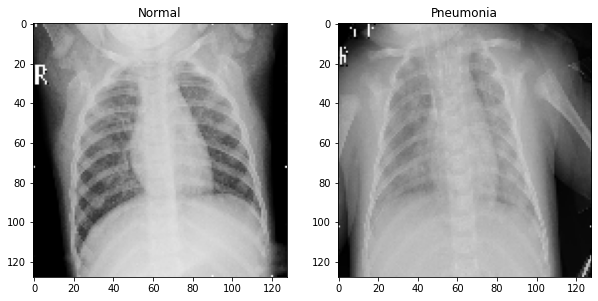

In [15]:
# Plot one image from each list 
# Choose the 1st image from each list
fig = plt.figure(figsize=(10,10))
n = 0

# Normal
ax1 = fig.add_subplot(121)
plt.imshow(X_val[normal_img_num[n]])
print(y_val[normal_img_num[n]])
plt.title("Normal");

# Pneumonia
ax2 = fig.add_subplot(122)
plt.imshow(X_val[pneumonia_img_num[n]])
print(y_val[pneumonia_img_num[n]])
plt.title("Pneumonia");

### Functions for Model Visualization and Evaluation

In [16]:
def visualize_training_results(history):
    '''
    Visualize the training results for train and test sets
    The 1st plot shows the Accuracy vs. Epochs
    The 2nd plot shows Loss vs. Epochs
    
    Input: Keras history object 
    
    Returns:
    -*-*-*-*-
    Accuracy vs. Epochs plot
    Loss vs. Epochs plot
    
    '''
    
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [17]:
def model_evaluation(model):
    '''
    Evaluate the neural network based on train and test prediction
    
    Input: Keras model
    
    Returns:
    -*-*-*-*-
    Confusion Matrix Plot
    Classification Report
    Train Accuracy, Test Accuracy
    
    '''
    
    train_acc = []
    test_acc = []
    
    # Train loss and accuracy
    result_train = model.evaluate(X_train, y_train)
    print(f'Training Loss:{result_train[0]:.4}')
    print(f'Training Accuracy:{result_train[1]:.4}')
    train_acc.append(round(result_train[1], 4))
    
    # Test loss and accuracy
    result_test = model.evaluate(X_test, y_test)
    print(f'Test Loss:{result_test[0]:.4}')
    print(f'Test Accuracy:{result_test[1]:.4}')
    test_acc.append(round(result_test[1], 4))
    
    # Prediction
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    ax.set_ylim(2,0)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.show()
    
    # Classification Report
    print(classification_report(y_test, y_test_pred))
    
    return train_acc, test_acc

## IV. Modeling

### CNN Baseline Model

In [ ]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D((2, 2)))

base_model.add(layers.Flatten())
base_model.add(layers.Dense(128, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
base_history = base_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 4s 22ms/step - loss: 0.2399 - accuracy: 0.9059 - val_loss: 0.8515 - val_accuracy: 0.7532
Epoch 2/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0937 - accuracy: 0.9661 - val_loss: 0.6915 - val_accuracy: 0.7853
Epoch 3/50
163/163 [==============================] - 3s 20ms/step - loss: 0.1005 - accuracy: 0.9638 - val_loss: 1.0843 - val_accuracy: 0.7420
Epoch 4/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0730 - accuracy: 0.9751 - val_loss: 1.1311 - val_accuracy: 0.7692
Epoch 5/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0549 - accuracy: 0.9799 - val_loss: 0.8473 - val_accuracy: 0.7997
Epoch 6/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0494 - accuracy: 0.9827 - val_loss: 1.4954 - val_accuracy: 0.7516
Epoch 7/50
163/163 [==============================] - 3s 21ms/step - loss: 0.0328 - accuracy: 0.9883 - val_loss: 1.2002 - val_accuracy: 0.7756

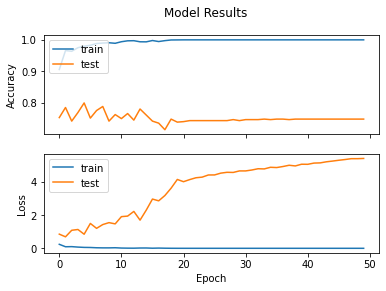

In [ ]:
visualize_training_results(base_history)

In [ ]:
base_model.save('/content/saved_models/base_model.h5')

163/163 [==============================] - 1s 8ms/step - loss: 1.3827e-06 - accuracy: 1.0000
Training Loss:1.383e-06
Training Accuracy:1.0
20/20 [==============================] - 0s 9ms/step - loss: 5.4036 - accuracy: 0.7484
Test Loss:5.404
Test Accuracy:0.7484


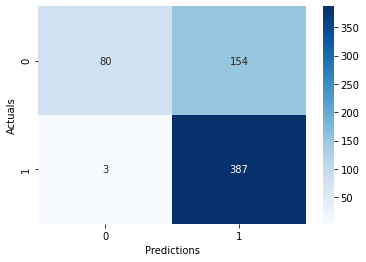

              precision    recall  f1-score   support

         0.0       0.96      0.34      0.50       234
         1.0       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



([1.0], [0.7484])

In [ ]:
base = load_model('/content/saved_models/base_model.h5')
bm = model_evaluation(base)
bm

#### Insight on *Baseline Model*
- The accuracy plot shows that test accuracy reaches convergence after 20 epochs 
- The loss plot shows that test loss still increase after 20 epochs
    - <b>Early stopping</b> can be used for iteration model tunning to prevent loss


- The train accuracy (1.0) is much higher than test accuracy (0.7484) which indicates that the baseline model is overfit
    - <b>Regularization</b> [techniques](https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/) can be applied to solve the overfitting issue
        - Dropout 
        - L1
        - L2 
        - L1+L2


- There are more false positive than false negative. A possible guess would be class imbalance problem because there are more positive (1, pneumonia) case than negative (0, normal) case during the training step
    - <b>Resample</b> techniques for balancing
        - sklearn computing class weight
        - SMOTE

#### Tunning Steps
- Add <b>padding</b> for more accurate analysis
- Add <b> early stopping</b> and <b> model checkpoint</b> when validation accuracy reaches max
- <b>Resample</b> techniques will be applied before <b>Regularization</b> techiniques
- Increase the depth of the CNN
- Backup options: pretrained network VGG19

### Note 3:
- Before *Increase the depth of the CNN*, all the models will use the same architecture except hyperparameter tunning

#### Early Stopping

In [18]:
# Early Stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=6)

### Resample

In [ ]:
def padding_model():
    '''
    Build a model with 3 blocks of convolutional layers and max pooling layers
    and 1 fully connected layer
    
    padding: same
    activation: relu for hidden and sigmoid for output
    
    Output: padding model
    '''
    
    # Build the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

#### a) Balanced weights by using [sklearn](https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras)

In [19]:
from sklearn.utils.class_weight import compute_class_weight

In [20]:
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

# Change to dictionary in oder to work in Keras
weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [ ]:
balanced_model = padding_model()

In [ ]:
mc_balanced = ModelCheckpoint(filepath='/content/saved_models/balanced_model.h5', 
                              monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
balanced_history = balanced_model.fit(X_train, y_train,
                                      epochs=50,
                                      batch_size=32,
                                      class_weight=weights_dict,
                                      callbacks=[es, mc_balanced],
                                      validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 5s 24ms/step - loss: 0.4076 - accuracy: 0.7918 - val_loss: 0.6747 - val_accuracy: 0.7997

Epoch 00001: val_accuracy improved from -inf to 0.79968, saving model to /content/saved_models/balanced_model.h5
Epoch 2/50
163/163 [==============================] - 4s 22ms/step - loss: 0.1030 - accuracy: 0.9637 - val_loss: 0.6164 - val_accuracy: 0.8109

Epoch 00002: val_accuracy improved from 0.79968 to 0.81090, saving model to /content/saved_models/balanced_model.h5
Epoch 3/50
163/163 [==============================] - 4s 23ms/step - loss: 0.0825 - accuracy: 0.9702 - val_loss: 1.0335 - val_accuracy: 0.7484

Epoch 00003: val_accuracy did not improve from 0.81090
Epoch 4/50
163/163 [==============================] - 4s 22ms/step - loss: 0.0680 - accuracy: 0.9751 - val_loss: 0.8607 - val_accuracy: 0.7853

Epoch 00004: val_accuracy did not improve from 0.81090
Epoch 5/50
163/163 [==============================] - 4s 22ms/step - loss: 0.0412 - a

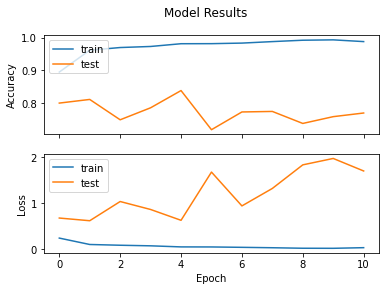

In [ ]:
visualize_training_results(balanced_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.0984 - accuracy: 0.9657
Training Loss:0.09845
Training Accuracy:0.9657
20/20 [==============================] - 0s 8ms/step - loss: 0.6256 - accuracy: 0.8381
Test Loss:0.6256
Test Accuracy:0.8381


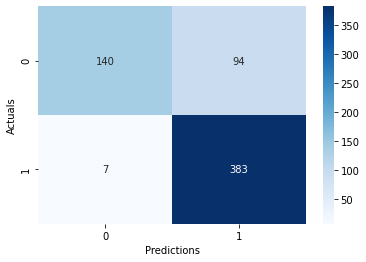

              precision    recall  f1-score   support

         0.0       0.95      0.60      0.73       234
         1.0       0.80      0.98      0.88       390

    accuracy                           0.84       624
   macro avg       0.88      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624



([0.9657], [0.8381])

In [ ]:
bal = load_model('/content/saved_models/balanced_model.h5')
bal_m = model_evaluation(bal)
bal_m

>**Comment:** *class_weight argument*
- After using the class_weight argument at fit step, there are less false positives (94) than the baseline model (154)
- The testing accuracy (0.8381) shows improvement compare with baseline model (0.7484)

#### b) SMOTE
By using SMOTE (Synthetic Minority Over-sampling Technique):
1. Change the 4D array to 2D
2. Transform
3. Change the 2D array back to 4D (otherwise it wont work at the fit step)

In [ ]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Originial was (5216, 128, 128, 3)
# 4D to 2D
XX_train = X_train.reshape(X_train.shape[0], -1)
yy_train = y_train.reshape(y_train.shape[0], -1)

print(XX_train.shape)
print(yy_train.shape)

(5216, 49152)
(5216, 1)


In [ ]:
# SMOTE transform
X_train_resampled, y_train_resampled = SMOTE().fit_resample(XX_train, yy_train)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(7750, 49152)
(7750,)


In [ ]:
# 2D to 4D
XXX_train = X_train_resampled.reshape((7750, 128, 128, 3))
yyy_train = y_train_resampled.reshape((7750,))

print(XXX_train.shape)
print(yyy_train.shape)

(7750, 128, 128, 3)
(7750,)


In [ ]:
smote_model = padding_model()

In [ ]:
mc_smote = ModelCheckpoint(filepath='/content/saved_models/smote_model.h5', 
                           monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
smote_history = smote_model.fit(XXX_train, yyy_train,
                                epochs=50,
                                batch_size=32,
                                callbacks=[es, mc_smote],
                                validation_data=(X_test, y_test))

Epoch 1/50
243/243 [==============================] - 6s 24ms/step - loss: 0.3859 - accuracy: 0.8107 - val_loss: 0.9444 - val_accuracy: 0.7804

Epoch 00001: val_accuracy improved from -inf to 0.78045, saving model to /content/saved_models/smote_model.h5
Epoch 2/50
243/243 [==============================] - 5s 22ms/step - loss: 0.0868 - accuracy: 0.9715 - val_loss: 1.5485 - val_accuracy: 0.6971

Epoch 00002: val_accuracy did not improve from 0.78045
Epoch 3/50
243/243 [==============================] - 5s 22ms/step - loss: 0.0575 - accuracy: 0.9792 - val_loss: 0.9335 - val_accuracy: 0.7981

Epoch 00003: val_accuracy improved from 0.78045 to 0.79808, saving model to /content/saved_models/smote_model.h5
Epoch 4/50
243/243 [==============================] - 5s 22ms/step - loss: 0.0427 - accuracy: 0.9862 - val_loss: 0.8376 - val_accuracy: 0.8237

Epoch 00004: val_accuracy improved from 0.79808 to 0.82372, saving model to /content/saved_models/smote_model.h5
Epoch 5/50
243/243 [=============

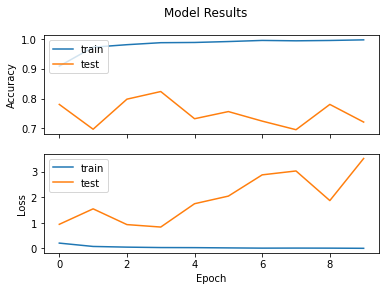

In [ ]:
visualize_training_results(smote_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1007 - accuracy: 0.9655
Training Loss:0.1007
Training Accuracy:0.9655
20/20 [==============================] - 0s 9ms/step - loss: 0.8376 - accuracy: 0.8237
Test Loss:0.8376
Test Accuracy:0.8237


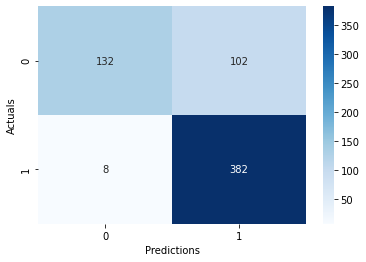

              precision    recall  f1-score   support

         0.0       0.94      0.56      0.71       234
         1.0       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



([0.9655], [0.8237])

In [ ]:
smo = load_model('/content/saved_models/smote_model.h5')
smo_m = model_evaluation(smo)
smo_m

>**Comment:** *SMOTE*
- After using the SMOTE transformation for the train set, there are less false positives (102) than the baseline model (154)
- The testing accuracy (0.8237) shows improvement compare with baseline model (0.7484)

#### Resample Method Choosing
- Sklearn Method has a higher test accuracy and f1-score than SMOTE, so the <b>class_weight</b> arguments will be used for further analysis

| Resample Method | Test Accuracy | F1-score |
| --- | --- | --- |
| Base | 0.7484 | 0.50 |
| Sklearn | 0.8381 | 0.73 |
| SMOTE | 0.8237 | 0.71 |

### 1) Grid Search for dropout %

In [ ]:
def dropout_model(percent):
    '''
    Define a model with unknown dropout rate
    So that this model can be applied to the Grid Search
    
    Input: dropout percent
    ex. 20% => 0.2
    
    Output: model with dropout rate

    '''
    
    # Build the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(percent))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

Implementation of the scikit-learn classifier [API for Keras](https://faroit.com/keras-docs/1.0.6/scikit-learn-api/)

In [ ]:
# Wrapper
DP_model = KerasClassifier(build_fn=dropout_model)

In [ ]:
# parameter grid for dropout rate
dp_param_grid = {'percent': [0.2, 0.3, 0.4, 0.5]}

# Grid Search
DP_grid = GridSearchCV(DP_model, param_grid=dp_param_grid, cv=3)

In [ ]:
DP_grid_history = DP_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              class_weight=weights_dict,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 4s 31ms/step - loss: 0.7846 - accuracy: 0.6409 - val_loss: 0.4435 - val_accuracy: 0.8173
Epoch 2/50
109/109 [==============================] - 3s 25ms/step - loss: 0.2308 - accuracy: 0.9082 - val_loss: 0.5988 - val_accuracy: 0.8077
Epoch 3/50
109/109 [==============================] - 3s 25ms/step - loss: 0.1468 - accuracy: 0.9497 - val_loss: 0.4336 - val_accuracy: 0.8349
Epoch 4/50
109/109 [==============================] - 3s 25ms/step - loss: 0.1053 - accuracy: 0.9622 - val_loss: 0.8484 - val_accuracy: 0.7901
Epoch 5/50
109/109 [==============================] - 3s 25ms/step - loss: 0.0726 - accuracy: 0.9701 - val_loss: 0.4285 - val_accuracy: 0.8365
Epoch 6/50
109/109 [==============================] - 3s 25ms/step - loss: 0.0919 - accuracy: 0.9662 - val_loss: 1.0248 - val_accuracy: 0.7692
Epoch 7/50
109/109 [==============================] - 3s 25ms/step - loss: 0.0603 - accuracy: 0.9756 - val_loss: 0.7916 - val_accuracy: 0.7981

In [ ]:
# Find the best dropout percent value
DP_grid_history.best_params_

{'percent': 0.3}

In [ ]:
DP_grid.best_estimator_

In [ ]:
model_evaluation(DP_grid.best_estimator_)

AttributeError: ignored

- KerasClassifier does not have an attribute of evaluate (which I used in the pre-defined model_evaluation function.
- So I need to manually input numbers to my model

####  Dropout 30

In [ ]:
dropout_30 = dropout_model(0.3)

In [ ]:
mc_dp_30 = ModelCheckpoint(filepath='/content/saved_models/dropout_30.h5', 
                           monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
dropout_30_history = dropout_30.fit(X_train, y_train,
                                    epochs=50,
                                    batch_size=32,
                                    class_weight=weights_dict,
                                    callbacks=[es, mc_dp_30],
                                    validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 5s 26ms/step - loss: 0.7941 - accuracy: 0.6693 - val_loss: 0.4388 - val_accuracy: 0.8237

Epoch 00001: val_accuracy improved from -inf to 0.82372, saving model to /content/saved_models/dropout_30.h5
Epoch 2/50
163/163 [==============================] - 4s 25ms/step - loss: 0.1977 - accuracy: 0.9305 - val_loss: 0.4488 - val_accuracy: 0.8429

Epoch 00002: val_accuracy improved from 0.82372 to 0.84295, saving model to /content/saved_models/dropout_30.h5
Epoch 3/50
163/163 [==============================] - 4s 25ms/step - loss: 0.1328 - accuracy: 0.9513 - val_loss: 0.6469 - val_accuracy: 0.7804

Epoch 00003: val_accuracy did not improve from 0.84295
Epoch 4/50
163/163 [==============================] - 4s 25ms/step - loss: 0.1092 - accuracy: 0.9612 - val_loss: 0.5191 - val_accuracy: 0.8157

Epoch 00004: val_accuracy did not improve from 0.84295
Epoch 5/50
163/163 [==============================] - 4s 24ms/step - loss: 0.0934 - accuracy:

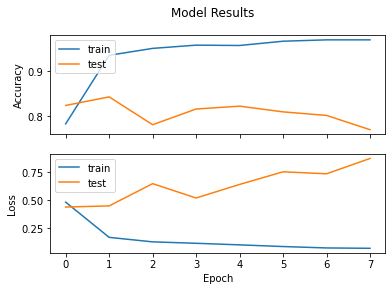

In [ ]:
visualize_training_results(dropout_30_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1232 - accuracy: 0.9548
Training Loss:0.1232
Training Accuracy:0.9548
20/20 [==============================] - 0s 9ms/step - loss: 0.4488 - accuracy: 0.8429
Test Loss:0.4488
Test Accuracy:0.8429


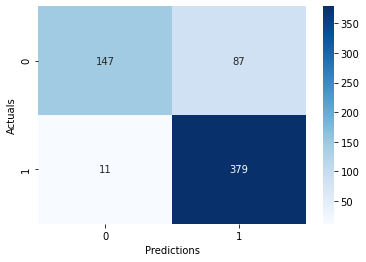

              precision    recall  f1-score   support

         0.0       0.93      0.63      0.75       234
         1.0       0.81      0.97      0.89       390

    accuracy                           0.84       624
   macro avg       0.87      0.80      0.82       624
weighted avg       0.86      0.84      0.83       624



([0.9548], [0.8429])

In [ ]:
dp30 = load_model('/content/saved_models/dropout_30.h5')
dp30m = model_evaluation(dp30)
dp30m

>**Comment:** *Dropout 30%*
- The testing accuracy of dp30m (0.8429) shows improvement compare with the model without dropout (0.8381) 
- The f1-score of dp30m (0.75) is higher than the model without dropout (0.73)

### 2) Grid Search For L2 weight decay

GridSearch https://heartbeat.fritz.ai/introduction-to-deep-learning-with-keras-c7c3d14e1527

In [ ]:
def L2_regularizer_model(weight_decay):
    '''
    Define a model with unknown weight decay for L2 regularizer
    So that this model can be applied to the Grid Search
    
    Input: weight_decay
    ex. 0.05
    
    Output: model with L2 regularizer

    '''
    
    # Build the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), 
                            activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), 
                            activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), 
                            activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
# Wrapper
L2_model = KerasClassifier(build_fn=L2_regularizer_model)

[Hyperperameter](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/) choosing

In [ ]:
# parameter grid for regularizer
reg_param_grid = {'weight_decay': [0.5, 0.05, 0.005, 0.0005]}

In [ ]:
# Grid Search
L2_grid = GridSearchCV(L2_model, param_grid=reg_param_grid, cv=3)

In [ ]:
L2_grid_history = L2_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              class_weight=weights_dict,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 26ms/step - loss: 28.8443 - accuracy: 0.6723 - val_loss: 0.7981 - val_accuracy: 0.8077
Epoch 2/50
109/109 [==============================] - 3s 24ms/step - loss: 0.5123 - accuracy: 0.8997 - val_loss: 0.5115 - val_accuracy: 0.8285
Epoch 3/50
109/109 [==============================] - 3s 24ms/step - loss: 0.3317 - accuracy: 0.9229 - val_loss: 0.4720 - val_accuracy: 0.8285
Epoch 4/50
109/109 [==============================] - 3s 24ms/step - loss: 0.3360 - accuracy: 0.9186 - val_loss: 0.6560 - val_accuracy: 0.7772
Epoch 5/50
109/109 [==============================] - 3s 24ms/step - loss: 0.2835 - accuracy: 0.9382 - val_loss: 0.5276 - val_accuracy: 0.8045
Epoch 6/50
109/109 [==============================] - 3s 24ms/step - loss: 0.2747 - accuracy: 0.9348 - val_loss: 0.8698 - val_accuracy: 0.7099
Epoch 7/50
109/109 [==============================] - 3s 24ms/step - loss: 0.3033 - accuracy: 0.9250 - val_loss: 0.4949 - val_accuracy: 0.815

In [ ]:
# Find the best weight_decay value
L2_grid_history.best_params_

{'weight_decay': 0.0005}

#### Regularizer (0.0005)

In [ ]:
L2_reg = L2_regularizer_model(0.0005)

In [ ]:
mc_L2_reg = ModelCheckpoint(filepath='/content/saved_models/L2_reg.h5', 
                            monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
L2_reg_history = L2_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            class_weight=weights_dict,
                            callbacks=[es, mc_L2_reg],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 5s 25ms/step - loss: 0.4327 - accuracy: 0.8057 - val_loss: 0.7506 - val_accuracy: 0.7837

Epoch 00001: val_accuracy improved from -inf to 0.78365, saving model to /content/saved_models/L2_reg.h5
Epoch 2/50
163/163 [==============================] - 4s 23ms/step - loss: 0.1414 - accuracy: 0.9659 - val_loss: 0.7580 - val_accuracy: 0.7933

Epoch 00002: val_accuracy improved from 0.78365 to 0.79327, saving model to /content/saved_models/L2_reg.h5
Epoch 3/50
163/163 [==============================] - 4s 24ms/step - loss: 0.1281 - accuracy: 0.9662 - val_loss: 0.9108 - val_accuracy: 0.7676

Epoch 00003: val_accuracy did not improve from 0.79327
Epoch 4/50
163/163 [==============================] - 4s 23ms/step - loss: 0.1058 - accuracy: 0.9750 - val_loss: 0.9280 - val_accuracy: 0.7901

Epoch 00004: val_accuracy did not improve from 0.79327
Epoch 5/50
163/163 [==============================] - 4s 24ms/step - loss: 0.0783 - accuracy: 0.9847 

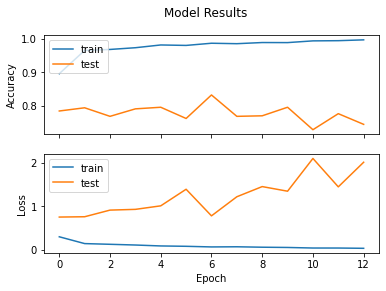

In [ ]:
visualize_training_results(L2_reg_history)

163/163 [==============================] - 2s 8ms/step - loss: 0.1150 - accuracy: 0.9705
Training Loss:0.115
Training Accuracy:0.9705
20/20 [==============================] - 0s 9ms/step - loss: 0.7784 - accuracy: 0.8317
Test Loss:0.7784
Test Accuracy:0.8317


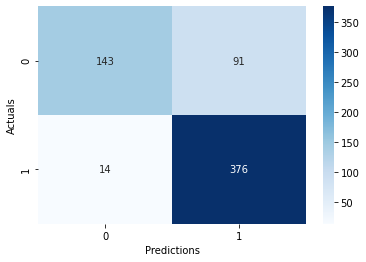

              precision    recall  f1-score   support

         0.0       0.91      0.61      0.73       234
         1.0       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.80       624
weighted avg       0.84      0.83      0.82       624



([0.9705], [0.8317])

In [ ]:
L2 = load_model('/content/saved_models/L2_reg.h5')
L2m = model_evaluation(L2)
L2m

>**Comment:** *L2(0.0005)*
- The testing accuracy of L2m (0.8317) did not show improvement compare with the model without regularizer (0.8381) 
- The f1-score of L2m (0.73) is the same as the model without regularizer (0.73)

### 3) Grid Search For L1 weight decay

In [ ]:
def L1_regularizer_model(weight_decay):
    '''
    Define a model with unknown weight decay for L1 regularizer
    So that this model can be applied to the Grid Search
    
    Input: weight_decay
    ex. 0.05
    
    Output: model with L1 regularizer

    '''
    
    # Build the model 
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l1(weight_decay), 
                                        activation='relu', input_shape=X_train.shape[1:]))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l1(weight_decay), 
                                        activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l1(weight_decay), 
                                         activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
# Wrapper
L1_model = KerasClassifier(build_fn=L1_regularizer_model)

In [ ]:
# Grid Search
L1_grid = GridSearchCV(L1_model, param_grid=reg_param_grid, cv=3)

In [ ]:
L1_grid_history = L1_grid.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              class_weight=weights_dict,
                              callbacks=es,
                              validation_data=(X_test, y_test))

Epoch 1/50
109/109 [==============================] - 3s 26ms/step - loss: 723.6553 - accuracy: 0.5668 - val_loss: 8.8216 - val_accuracy: 0.3750
Epoch 2/50
109/109 [==============================] - 3s 24ms/step - loss: 7.2158 - accuracy: 0.2568 - val_loss: 6.4196 - val_accuracy: 0.3750
Epoch 3/50
109/109 [==============================] - 3s 24ms/step - loss: 6.4290 - accuracy: 0.3189 - val_loss: 6.4212 - val_accuracy: 0.3750
Epoch 4/50
109/109 [==============================] - 3s 24ms/step - loss: 6.4324 - accuracy: 0.2578 - val_loss: 6.4472 - val_accuracy: 0.3750
Epoch 5/50
109/109 [==============================] - 3s 24ms/step - loss: 6.4348 - accuracy: 0.2607 - val_loss: 6.4276 - val_accuracy: 0.3750
Epoch 6/50
109/109 [==============================] - 3s 24ms/step - loss: 6.4300 - accuracy: 0.2592 - val_loss: 6.4841 - val_accuracy: 0.3750
Epoch 7/50
109/109 [==============================] - 3s 23ms/step - loss: 6.4432 - accuracy: 0.2658 - val_loss: 6.4091 - val_accuracy: 0.37

In [ ]:
# Find the best weight_decay value
L1_grid_history.best_params_

{'weight_decay': 0.0005}

#### L1 Regularizer (0.0005)

In [ ]:
L1_reg = L1_regularizer_model(0.0005)

In [ ]:
mc_L1_reg = ModelCheckpoint(filepath='/content/saved_models/L1_reg.h5', 
                             monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
L1_reg_history = L1_reg.fit(X_train, y_train,
                            epochs=50,
                            batch_size=32,
                            class_weight=weights_dict,
                            callbacks=[es, mc_L1_reg],
                            validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 4s 24ms/step - loss: 1.3070 - accuracy: 0.7413 - val_loss: 0.9178 - val_accuracy: 0.7308

Epoch 00001: val_accuracy improved from -inf to 0.73077, saving model to /content/saved_models/L1_reg.h5
Epoch 2/50
163/163 [==============================] - 4s 23ms/step - loss: 0.3767 - accuracy: 0.9554 - val_loss: 0.6022 - val_accuracy: 0.8317

Epoch 00002: val_accuracy improved from 0.73077 to 0.83173, saving model to /content/saved_models/L1_reg.h5
Epoch 3/50
163/163 [==============================] - 4s 23ms/step - loss: 0.2402 - accuracy: 0.9638 - val_loss: 0.7293 - val_accuracy: 0.8045

Epoch 00003: val_accuracy did not improve from 0.83173
Epoch 4/50
163/163 [==============================] - 4s 23ms/step - loss: 0.2131 - accuracy: 0.9620 - val_loss: 0.9119 - val_accuracy: 0.7724

Epoch 00004: val_accuracy did not improve from 0.83173
Epoch 5/50
163/163 [==============================] - 4s 23ms/step - loss: 0.1585 - accuracy: 0.9770 

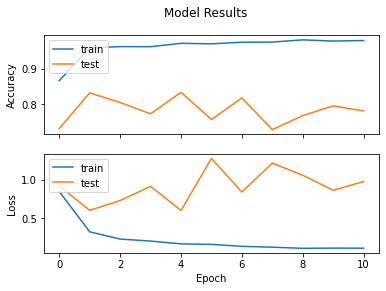

In [ ]:
visualize_training_results(L1_reg_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.2530 - accuracy: 0.9398
Training Loss:0.253
Training Accuracy:0.9398
20/20 [==============================] - 0s 8ms/step - loss: 0.6010 - accuracy: 0.8333
Test Loss:0.601
Test Accuracy:0.8333


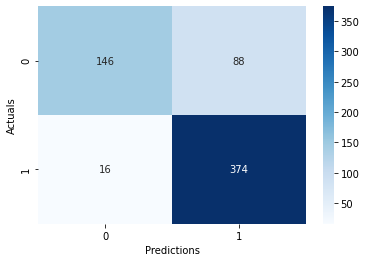

              precision    recall  f1-score   support

         0.0       0.90      0.62      0.74       234
         1.0       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.79      0.81       624
weighted avg       0.84      0.83      0.83       624



([0.9398], [0.8333])

In [ ]:
L1 = load_model('/content/saved_models/L1_reg.h5')
L1m = model_evaluation(L1)
L1m

>**Comment:** *L1(0.0005)*
- The testing accuracy of L1m (0.8333) did not show improvement compare with the model without regularizer (0.8381) 
- The f1-score of L1m (0.74) is higher than the model without regularizer (0.73)

### 4) L1 + L2
- use the best weight decay value from grid search of L1 and L2 regularizer models

In [ ]:
def L1_L2_regularizer_model(wd_1, wd_2):
    '''
    Build a model with both L1 and L2 regularizer
    
    Input: weight_decay 1 and weight_decay 2
    ex. 0.05, 0.005
    
    Output: L1 and L2 regularizer model
    '''
    
    # Build the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                                        activation='relu', input_shape=(128,128,3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                                        activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l1_l2(l1=wd_1, l2=wd_2), 
                                         activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
# Wrapper
L1L2 = L1_L2_regularizer_model(0.0005, 0.0005)

In [ ]:
mc_L1L2 = ModelCheckpoint(filepath='/content/saved_models/L1L2.h5', 
                          monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
L1L2_history = L1L2.fit(X_train, y_train,
                        epochs=50,
                        batch_size=32,
                        class_weight=weights_dict,
                        callbacks=[es, mc_L1L2],
                        validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 5s 25ms/step - loss: 1.2969 - accuracy: 0.8356 - val_loss: 1.1240 - val_accuracy: 0.7580

Epoch 00001: val_accuracy improved from -inf to 0.75801, saving model to /content/saved_models/L1L2.h5
Epoch 2/50
163/163 [==============================] - 4s 23ms/step - loss: 0.3711 - accuracy: 0.9605 - val_loss: 0.8828 - val_accuracy: 0.7516

Epoch 00002: val_accuracy did not improve from 0.75801
Epoch 3/50
163/163 [==============================] - 4s 23ms/step - loss: 0.2853 - accuracy: 0.9567 - val_loss: 0.8705 - val_accuracy: 0.7692

Epoch 00003: val_accuracy improved from 0.75801 to 0.76923, saving model to /content/saved_models/L1L2.h5
Epoch 4/50
163/163 [==============================] - 4s 23ms/step - loss: 0.2175 - accuracy: 0.9635 - val_loss: 0.7583 - val_accuracy: 0.8061

Epoch 00004: val_accuracy improved from 0.76923 to 0.80609, saving model to /content/saved_models/L1L2.h5
Epoch 5/50
163/163 [==============================] - 

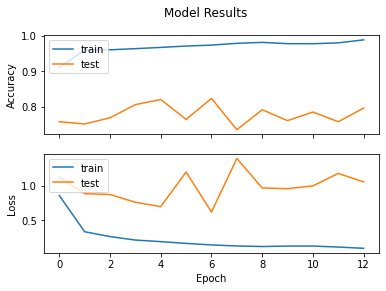

In [ ]:
visualize_training_results(L1L2_history)

163/163 [==============================] - 1s 8ms/step - loss: 0.1567 - accuracy: 0.9714
Training Loss:0.1567
Training Accuracy:0.9714
20/20 [==============================] - 0s 9ms/step - loss: 0.6177 - accuracy: 0.8237
Test Loss:0.6177
Test Accuracy:0.8237


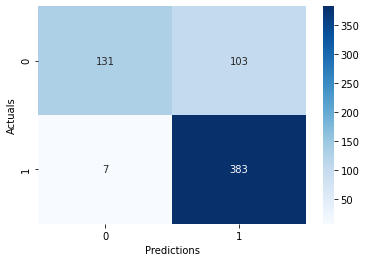

              precision    recall  f1-score   support

         0.0       0.95      0.56      0.70       234
         1.0       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



([0.9714], [0.8237])

In [ ]:
L1L2_best = load_model('/content/saved_models/L1L2.h5')
L1L2_best_m = model_evaluation(L1L2_best)
L1L2_best_m

>**Comment:** *L1(0.0005) L2(0.0005)*
- The testing accuracy of L1L2_best_m (0.8237) did not show improvement compare with the model without regularizer (0.8381) 
- The f1-score of L1L2_best_m (0.70) is lower than the model without regularizer (0.73)

#### Regularization Technique Choosing
- Dropout has the highest test accuracy and f1-score among the 4 regularization techiques, so <b>dropout 30%</b> will be used for further analysis

| Regularization Method | Test Accuracy | F1-score |
| --- | --- | --- |
| Base | 0.7484 | 0.50 |
| Dropout | 0.8381 | 0.75 |
| L2 | 0.8317 | 0.73 |
| L1 | 0.8333 | 0.74 |
| L1L2 | 0.8237 | 0.70 |

### Increase the Depth

In [21]:
def block_model(block_4=True, block_5=True):
    '''
    
    Define a model with unknown number of blocks
    (Either 4 blocks or 5 blocks)
    
    block_4 and block_5 should be boolean value
    Only one True is present
    
    ex. block_4=True, block_5=False
    
    Input: Boolean
    
    Return: block model
    
    '''
    
    if block_4 == True:
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
    
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
            
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    elif block_5 == True:
        model = models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    else:
        print("error")
    
    return model

#### 4 blocks

In [22]:
block_4 = block_model(block_4=True, block_5=False)

In [23]:
# Check
block_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

In [24]:
mc_b4 = ModelCheckpoint(filepath='/content/saved_models/block_4.h5', 
                        monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [26]:
block_4_history = block_4.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              class_weight=weights_dict,
                              callbacks=[es, mc_b4],
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 16ms/step - loss: 0.4980 - accuracy: 0.7304 - val_loss: 0.3702 - val_accuracy: 0.8397

Epoch 00001: val_accuracy improved from -inf to 0.83974, saving model to /content/saved_models/block_4.h5
Epoch 2/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1738 - accuracy: 0.9340 - val_loss: 0.6038 - val_accuracy: 0.8237

Epoch 00002: val_accuracy did not improve from 0.83974
Epoch 3/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1350 - accuracy: 0.9521 - val_loss: 0.5839 - val_accuracy: 0.8029

Epoch 00003: val_accuracy did not improve from 0.83974
Epoch 4/50
163/163 [==============================] - 2s 15ms/step - loss: 0.1171 - accuracy: 0.9536 - val_loss: 0.4907 - val_accuracy: 0.8413

Epoch 00004: val_accuracy improved from 0.83974 to 0.84135, saving model to /content/saved_models/block_4.h5
Epoch 5/50
163/163 [==============================] - 2s 15ms/step - loss: 0.0952 - accuracy: 0.968

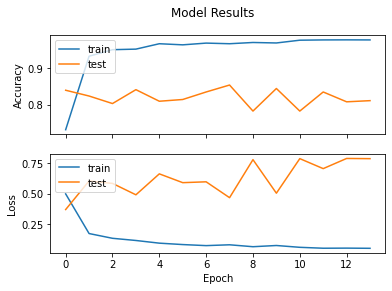

In [27]:
visualize_training_results(block_4_history)

163/163 [==============================] - 1s 6ms/step - loss: 0.1519 - accuracy: 0.9396
Training Loss:0.1519
Training Accuracy:0.9396
20/20 [==============================] - 0s 7ms/step - loss: 0.4672 - accuracy: 0.8542
Test Loss:0.4672
Test Accuracy:0.8542


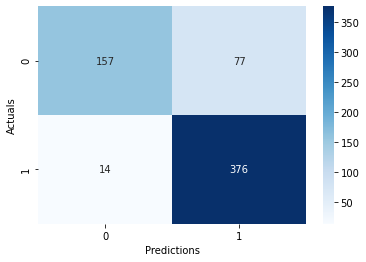

              precision    recall  f1-score   support

         0.0       0.92      0.67      0.78       234
         1.0       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



([0.9396], [0.8542])

In [28]:
b4 = load_model('/content/saved_models/block_4.h5')
b4m = model_evaluation(b4)
b4m

>**Comment:** *4 blocks*
- The testing accuracy of b4m (0.8534) shows improvement compare with the 3 block model (0.8429) 
- The f1-score of b4m (0.78) is higher than 3 block model (0.75)

#### 5 blocks

In [29]:
block_5 = block_model(block_4=False, block_5=True)

In [30]:
block_5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)      

In [31]:
mc_b5 = ModelCheckpoint(filepath='/content/saved_models/block_5.h5', 
                        monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [32]:
block_5_history = block_5.fit(X_train, y_train,
                              epochs=50,
                              batch_size=32,
                              class_weight=weights_dict,
                              callbacks=[es, mc_b5],
                              validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 3s 17ms/step - loss: 0.7514 - accuracy: 0.4997 - val_loss: 0.5168 - val_accuracy: 0.7933

Epoch 00001: val_accuracy improved from -inf to 0.79327, saving model to /content/saved_models/block_5.h5
Epoch 2/50
163/163 [==============================] - 3s 16ms/step - loss: 0.3512 - accuracy: 0.8441 - val_loss: 0.5212 - val_accuracy: 0.8574

Epoch 00002: val_accuracy improved from 0.79327 to 0.85737, saving model to /content/saved_models/block_5.h5
Epoch 3/50
163/163 [==============================] - 3s 16ms/step - loss: 0.1673 - accuracy: 0.9316 - val_loss: 0.4807 - val_accuracy: 0.8782

Epoch 00003: val_accuracy improved from 0.85737 to 0.87821, saving model to /content/saved_models/block_5.h5
Epoch 4/50
163/163 [==============================] - 3s 16ms/step - loss: 0.1245 - accuracy: 0.9445 - val_loss: 0.4733 - val_accuracy: 0.8606

Epoch 00004: val_accuracy did not improve from 0.87821
Epoch 5/50
163/163 [=========================

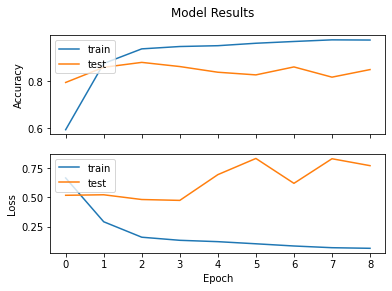

In [33]:
visualize_training_results(block_5_history)

163/163 [==============================] - 1s 6ms/step - loss: 0.1547 - accuracy: 0.9385
Training Loss:0.1547
Training Accuracy:0.9385
20/20 [==============================] - 0s 7ms/step - loss: 0.4807 - accuracy: 0.8782
Test Loss:0.4807
Test Accuracy:0.8782


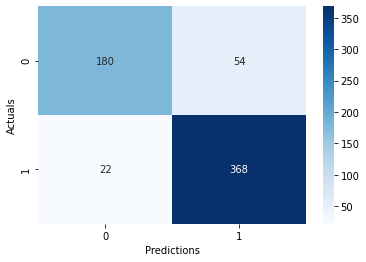

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83       234
         1.0       0.87      0.94      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



([0.9385], [0.8782])

In [34]:
b5 = load_model('/content/saved_models/block_5.h5')
b5m = model_evaluation(b5)
b5m

>**Comment:** *4 blocks*
- The testing accuracy of b5m (0.8782) shows improvement compare with the 3 block model (0.8429) 
- The f1-score of b5m (0.83) is higher than 3 block model (0.75)

#### Model Depth Choosing
- 5 blocks of CNN has the highest test accuracy and f1-score. And this is the best model so far.

| Model Depth | Test Accuracy | F1-score |
| --- | --- | --- |
| Base | 0.7484 | 0.50 |
| 3 blocks | 0.8381 | 0.73 |
| 4 blocks | 0.8542 | 0.78 |
| 5 blocks | 0.8782 | 0.83 |

### Backup: Pretrained VGG19

In [ ]:
from keras.applications import VGG19

In [ ]:
pretrained = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=X_train.shape[1:])

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# Build the model
pre = models.Sequential()
# Add pretained layer
pre.add(pretrained)

# Adding own layer
pre.add(layers.Flatten())
pre.add(layers.Dense(128, activation='relu'))
pre.add(layers.Dense(1, activation='sigmoid'))

# Freeze pretained layer
pretrained.trainable = False

In [ ]:
pre.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_44 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_88 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Verify "frozen"
for layer in pre.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_44 True
dense_88 True
dense_89 True


In [ ]:
# Compile the model
pre.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [ ]:
mc_pre = ModelCheckpoint(filepath='/content/saved_models/pre.h5', 
                         monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
pre_history = pre.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      class_weight=weights_dict,
                      callbacks=[es, mc_pre],
                      validation_data=(X_test, y_test))

Epoch 1/50
163/163 [==============================] - 14s 64ms/step - loss: 0.3262 - accuracy: 0.8637 - val_loss: 0.6762 - val_accuracy: 0.7869

Epoch 00001: val_accuracy improved from -inf to 0.78686, saving model to /content/saved_models/pre.h5
Epoch 2/50
163/163 [==============================] - 9s 55ms/step - loss: 0.1022 - accuracy: 0.9628 - val_loss: 0.6409 - val_accuracy: 0.8189

Epoch 00002: val_accuracy improved from 0.78686 to 0.81891, saving model to /content/saved_models/pre.h5
Epoch 3/50
163/163 [==============================] - 9s 55ms/step - loss: 0.0675 - accuracy: 0.9756 - val_loss: 0.7163 - val_accuracy: 0.8237

Epoch 00003: val_accuracy improved from 0.81891 to 0.82372, saving model to /content/saved_models/pre.h5
Epoch 4/50
163/163 [==============================] - 9s 56ms/step - loss: 0.0576 - accuracy: 0.9780 - val_loss: 0.6090 - val_accuracy: 0.8462

Epoch 00004: val_accuracy improved from 0.82372 to 0.84615, saving model to /content/saved_models/pre.h5
Epoch 

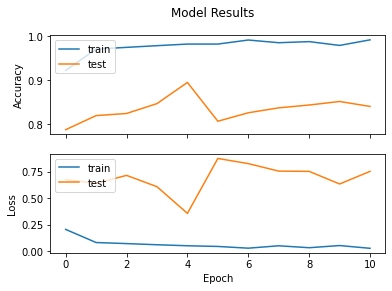

In [ ]:
visualize_training_results(pre_history)

163/163 [==============================] - 8s 49ms/step - loss: 0.1894 - accuracy: 0.9289
Training Loss:0.1894
Training Accuracy:0.9289
20/20 [==============================] - 1s 48ms/step - loss: 0.3557 - accuracy: 0.8942
Test Loss:0.3557
Test Accuracy:0.8942


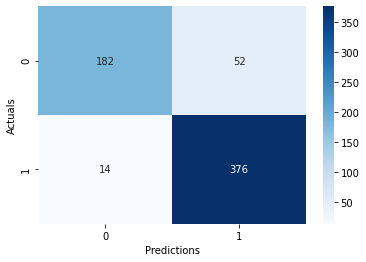

              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85       234
         1.0       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



([0.9289], [0.8942])

In [ ]:
pret = load_model('/content/saved_models/pre.h5')
PRE = model_evaluation(pret)
PRE

### Best Model Selection
- Overall, pretrained VGG19 has the highest accuracy and f1-score, however, it's computational cost expensively without GPU processing (time consuming). So I would chose use 5 blocks of CNN as my best model

| Model | Test Accuracy | F1-score |
| --- | --- | --- |
| Base | 0.7484 | 0.50 |
| 5 blocks | 0.8782 | 0.83 |
| Pretrained| 0.8942 | 0.85 |

## V. Evaluation
Reading every x-ray image for a doctor will become overload for some situations. It would become more efficient for doctors to review those pneumonia x-ray images only.  In the case of diagnosing pneumonia through machine learning, we expect to utilize a model with higher accuracy while having fewer false positives and false negatives. In the real situation, if the model predicts the result to be pneumonia, then the x-rays images will be sent to doctors and look through again to see how severe the condition is. Misclassifying someone to be non-pneumonia (false negatives) will cause delay or lack of supportive treatments. To solve the misclassify issue, we can set a threshold for predicting probabilities. For those results within the range, those images can be sent to medical intern students for preview (also work as a practice for them). So that, if it is pneumonia, then re-send to the doctor for final review.

163/163 [==============================] - 1s 6ms/step - loss: 0.1547 - accuracy: 0.9385
Training Loss:0.1547
Training Accuracy:0.9385
20/20 [==============================] - 0s 7ms/step - loss: 0.4807 - accuracy: 0.8782
Test Loss:0.4807
Test Accuracy:0.8782


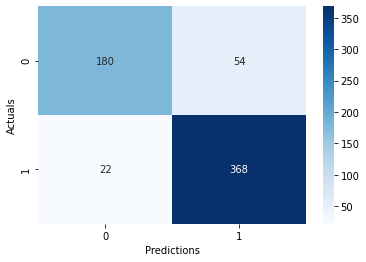

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83       234
         1.0       0.87      0.94      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



([0.9385], [0.8782])

In [35]:
best = load_model('/content/saved_models/block_5.h5')
BEST = model_evaluation(best)
BEST

In [36]:
# Use the best model and make evaluation on the holdout (validation set)
best.evaluate(X_val, y_val)

1/1 [==============================] - 0s 30ms/step - loss: 0.2153 - accuracy: 0.9375


[0.21526235342025757, 0.9375]

- predict method can be used to find the probability of getting pneumonia in this case

In [37]:
# Preview the prediction of probability for getting 1
best.predict(X_val)

# predict_proba was deprecated

array([[0.997076],
       [0.200948],
       [0.319139],
       [0.17253 ],
       [0.95486 ],
       [0.101858],
       [0.030585],
       [0.823204],
       [0.139929],
       [0.273736],
       [0.999988],
       [0.980606],
       [0.224292],
       [0.581428],
       [0.062042],
       [0.855796]], dtype=float32)

In [38]:
# Flatten the array
val_prob = best.predict(X_val).flatten()
val_prob

array([0.997076, 0.200948, 0.319139, 0.17253 , 0.95486 , 0.101858,
       0.030585, 0.823204, 0.139929, 0.273736, 0.999988, 0.980606,
       0.224292, 0.581428, 0.062042, 0.855796], dtype=float32)

In [39]:
# Get the prediction (1 or 0) by using the best model
y_val_pred = ((best.predict(X_val) > 0.5).astype("int32")).flatten()
y_val_pred

# pad.predict_classes(X_val) was deprecated

array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1], dtype=int32)

In [40]:
# Flatten the acutal
y_val_act = y_val.astype("int32").flatten()
y_val_act

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1], dtype=int32)

In [41]:
# Put the actual, prediction and probabilities together
compare_val_df = pd.concat([pd.Series(y_val_act, name="Actual"),
                            pd.Series(y_val_pred, name="Predicted"),
                            pd.Series(val_prob, name="Probabilities")], axis=1)

In [42]:
compare_val_df

,Actual,Predicted,Probabilities
0,1,1,0.997076
1,0,0,0.200948
2,1,0,0.319139
3,0,0,0.172530
4,1,1,0.954860
5,0,0,0.101858
6,0,0,0.030585
7,1,1,0.823204
8,0,0,0.139929
9,0,0,0.273736


Perform the same steps for test set so that we can determine the threshold.

In [43]:
# Probabilities of geting 1
test_prob = best.predict(X_test).flatten()

In [44]:
# Prediction
y_test_pred = ((best.predict(X_test) > 0.5).astype("int32")).flatten()

In [45]:
# Actual
y_test_act = y_test.astype("int32").flatten()

In [46]:
# Put in the same dataframe
compare_test_df = pd.concat([pd.Series(y_test_act, name="Actual"),
                             pd.Series(y_test_pred, name="Predicted"),
                             pd.Series(test_prob, name="Probabilities")], axis=1)

In [47]:
compare_test_df

,Actual,Predicted,Probabilities
0,0,1,0.996690
1,1,1,0.998843
2,1,1,0.981023
3,0,0,0.029024
4,0,0,0.027391
...,...,...,...
619,1,1,0.999678
620,1,1,0.999954
621,1,1,0.983717
622,1,1,0.998492


In [48]:
# Save the test result df
compare_test_df.to_csv('/content/compare_test_df.csv')

In [49]:
# Save the val result df
compare_val_df.to_csv('/content/compare_val_df.csv')

#### Analyze the Threshold (for recommendation)
- Steps perform in local

In [1]:
import pandas as pd

In [2]:
# Read the validation result
df_val = pd.read_csv('saved_csv/compare_val_df.csv', index_col=0)
df_val

,Actual,Predicted,Probabilities
0,1,1,0.997076
1,0,0,0.200948
2,1,0,0.319139
3,0,0,0.172530
4,1,1,0.954860
5,0,0,0.101858
6,0,0,0.030585
7,1,1,0.823204
8,0,0,0.139929
9,0,0,0.273736


In [4]:
# Find the case where my best model predicts incorrectly
df_val.loc[df_val['Actual'] != df_val['Predicted']]

,Actual,Predicted,Probabilities
2,1,0,0.319139


- My best model only makes one incorrect prediction

In [5]:
# Read the test result
df_test = pd.read_csv('saved_csv/compare_test_df.csv', index_col=0)
df_test.head()

,Actual,Predicted,Probabilities
0,0,1,0.996690
1,1,1,0.998843
2,1,1,0.981023
3,0,0,0.029024
4,0,0,0.027391


In [6]:
# Add an extra column to indicate whether the model predict correctly or not
df_test.loc[df_test['Predicted'] != df_test['Actual'], "Right?"] = "wrong"
df_test.loc[df_test['Predicted'] == df_test['Actual'], "Right?"] = "correct"

In [7]:
df_test.head()

,Actual,Predicted,Probabilities,Right?
0,0,1,0.996690,wrong
1,1,1,0.998843,correct
2,1,1,0.981023,correct
3,0,0,0.029024,correct
4,0,0,0.027391,correct


In [8]:
# Check if match with confusion matrix
df_test['Right?'].value_counts()

correct    548
wrong       76
Name: Right?, dtype: int64

In [10]:
# Sub-df for predicting wrong
df_wrong = df_test.loc[df_test['Right?'] == "wrong"]
df_wrong.head()

,Actual,Predicted,Probabilities,Right?
0,0,1,0.996690,wrong
21,1,0,0.411514,wrong
31,0,1,0.949478,wrong
34,0,1,0.825544,wrong
37,1,0,0.100919,wrong


In [11]:
# Sub-df for predicting correctly
df_right = df_test.loc[df_test['Right?'] == "correct"]
df_right.head()

,Actual,Predicted,Probabilities,Right?
1,1,1,0.998843,correct
2,1,1,0.981023,correct
3,0,0,0.029024,correct
4,0,0,0.027391,correct
5,1,1,0.995464,correct


In [12]:
# sub-df from df_wrong: finding the false negative
df_wrong_1 = df_wrong.loc[df_wrong['Actual'] == 1]
df_wrong_1.sort_values(by='Probabilities')

,Actual,Predicted,Probabilities,Right?
368,1,0,0.065646,wrong
360,1,0,0.073853,wrong
518,1,0,0.086183,wrong
584,1,0,0.088093,wrong
327,1,0,0.098597,wrong
37,1,0,0.100919,wrong
568,1,0,0.104224,wrong
141,1,0,0.109533,wrong
400,1,0,0.128527,wrong
560,1,0,0.147944,wrong


In [13]:
df_wrong_1.describe()

,Actual,Predicted,Probabilities
count,22.0,22.0,22.000000
mean,1.0,0.0,0.232261
std,0.0,0.0,0.140631
min,1.0,0.0,0.065646
25%,1.0,0.0,0.101746
50%,1.0,0.0,0.190812
75%,1.0,0.0,0.356472
max,1.0,0.0,0.492569


- For those predicting incorrectly, the probability is the range between 0.0656 ~ 0.4926

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

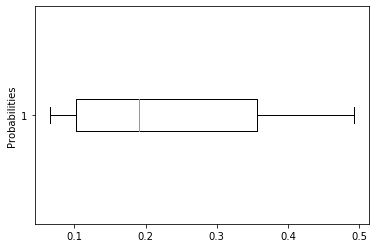

In [19]:
# View as a boxplot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(df_wrong_1['Probabilities'], vert=False);
plt.ylabel('Probabilities')

In [14]:
# sub-df from df_right: finding the true positives
df_right_1 = df_right.loc[df_right['Actual'] == 1]
df_right_1.sort_values(by='Probabilities')

,Actual,Predicted,Probabilities,Right?
51,1,1,0.501672,correct
576,1,1,0.511709,correct
387,1,1,0.520454,correct
328,1,1,0.532231,correct
371,1,1,0.548417,correct
...,...,...,...,...
476,1,1,1.000000,correct
269,1,1,1.000000,correct
451,1,1,1.000000,correct
61,1,1,1.000000,correct


In [15]:
df_right_1.describe()

,Actual,Predicted,Probabilities
count,368.0,368.0,368.000000
mean,1.0,1.0,0.960773
std,0.0,0.0,0.094520
min,1.0,1.0,0.501672
25%,1.0,1.0,0.984300
50%,1.0,1.0,0.997021
75%,1.0,1.0,0.999717
max,1.0,1.0,1.000000


- For those predicting correctly, the probability is the range between 0.5016 ~ 1.00

In [16]:
# Check
df_right_1.loc[df_right_1['Probabilities']<=0.5].sort_values(by='Probabilities')

,Actual,Predicted,Probabilities,Right?


- If the predicting probability of getting 1 (pneumonia) is in the range 0% < p < 50%, then the image should be sent to a medical intern students for preview

#### Visualization
- for presentation

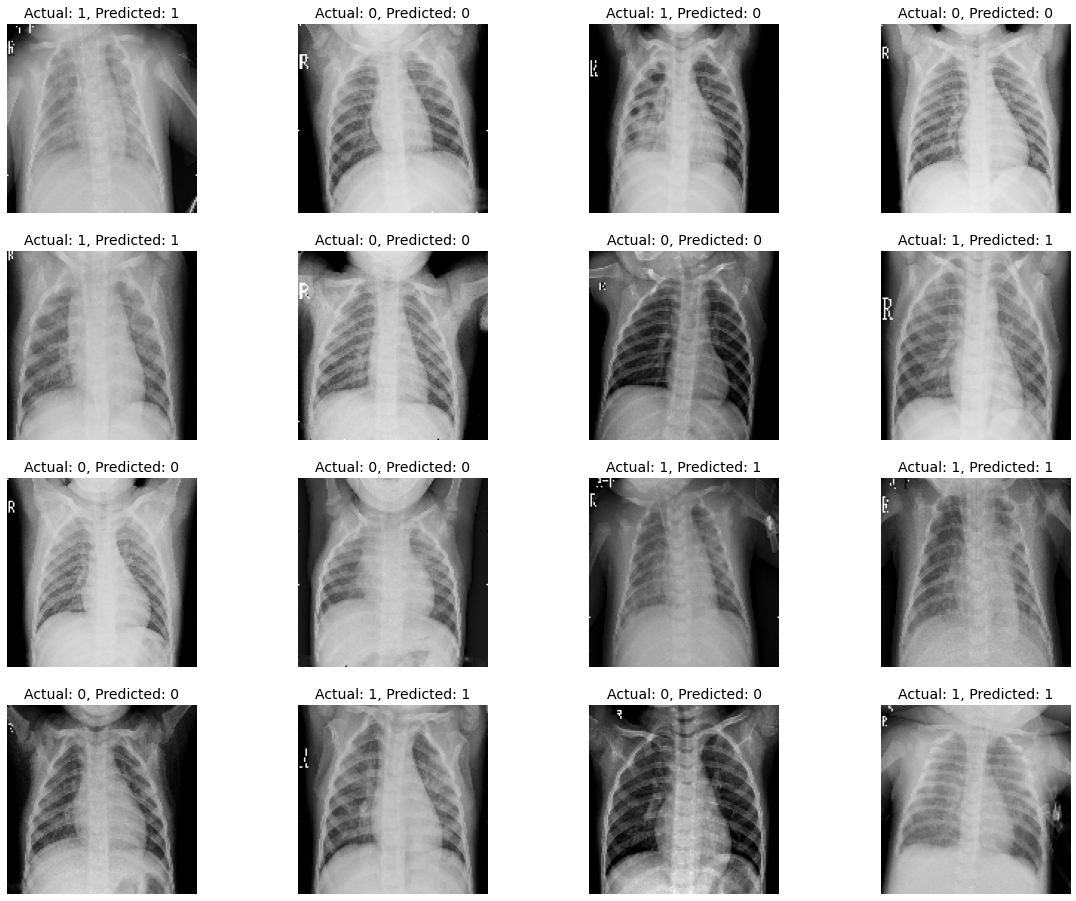

In [50]:
plt.figure(figsize=(20,16))
for i,x in enumerate(X_val):
    plt.subplot(4, 4, i+1)
    plt.imshow(x)
    plt.axis('off')
    plt.title("Actual: {}, Predicted: {}".format(y_val_act[i], y_val_pred[i]), fontsize=14)

    
plt.savefig('val_result.png', dpi=300, bbox_inches='tight')

- 1st row, 3rd column is the one predicted incorrectly

## VI. Conclusion
Among analyze 5856 chest x-ray images, a convolutional neural network was built for image classification. After hyperparameter tunning, my best model's test accuracy has reached 87.82%. Rather than sending every x-rays image to doctors, the radiology department can use my model to filter "pneumonia" and "normal" x-ray images. Those predicting probabilities fill in the range 0% < p < 50% will be sent to medical intern students before a doctor's final review.

#### Recommendation
- Saved the x-ray images' size as 128×128 px

#### Future Work
Further analysis can be explored on the following to provide additional insights and improve the model performance.
- Try different model architecture
- Acquire more normal chest x-ray to see if can reduct false positives